Weighted Recall (R): 0.8867
Weighted Precision (P): 0.9568
F_beta^w score: 0.9397


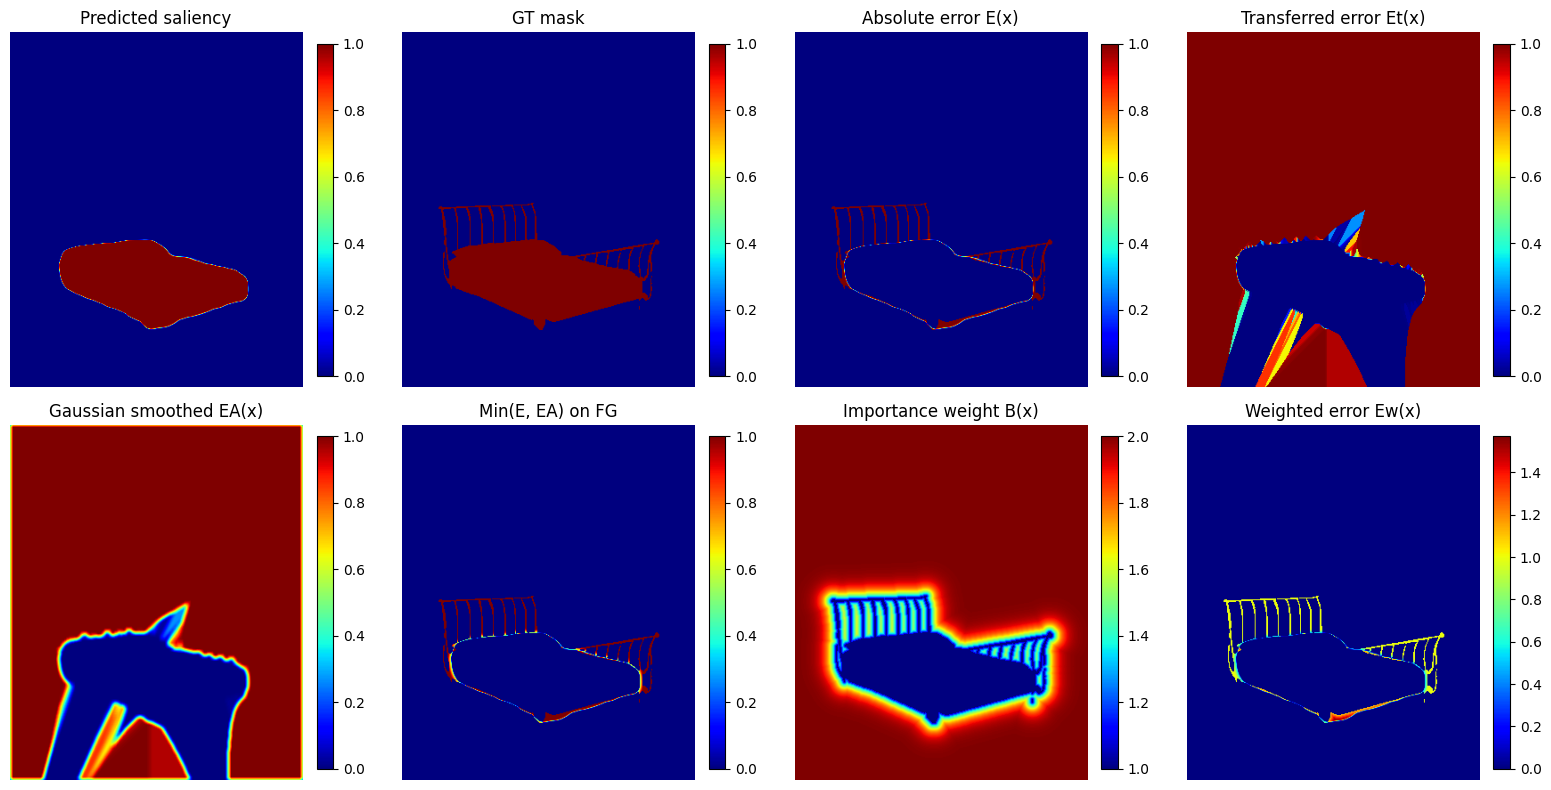

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import distance_transform_edt, gaussian_filter
from PIL import Image

# ====== CONFIG ======
gt_path = "./gt/Dataset_1/im005.png"   # path to predicted saliency map (0-255 or 0-1 grayscale)
pred_path = "./pred/Method_1/Dataset_1/im005.png"       # path to ground truth mask (binary or grayscale)
threshold_sal, upper_sal, lower_sal = 0.5, 1, 0
sigma = 5.0
beta2 = 0.3
eps = np.spacing(1)

# ====== LOAD IMAGES ======
pred = np.array(Image.open(pred_path).convert("L"), dtype=np.float32) / 255.0
gt = np.array(Image.open(gt_path).convert("L"), dtype=np.float32) / 255.0

# Binarize GT if needed
if not np.all((gt == 0) | (gt == 1)):
    gt[gt > threshold_sal] = upper_sal
    gt[gt <= threshold_sal] = lower_sal

gt_mask = np.isclose(gt, 1)
not_gt_mask = ~gt_mask

# ====== STEP 1: Absolute pixel error ======
E = np.abs(pred - gt)

# ====== STEP 2: Pixel dependency (nearest foreground) ======
dist, idx = distance_transform_edt(not_gt_mask, return_indices=True)
Et = np.array(E)
Et[not_gt_mask] = E[idx[0, not_gt_mask], idx[1, not_gt_mask]]

# ====== STEP 3: Gaussian smoothing ======
EA = gaussian_filter(Et, sigma=sigma, truncate=3 / sigma, mode='constant', cval=0.0)

# ====== STEP 4: Min(E, EA) for foreground ======
min_E_EA = np.array(E)
min_E_EA[gt_mask] = np.minimum(E[gt_mask], EA[gt_mask])

# ====== STEP 5: Importance weighting ======
B = np.ones_like(gt)
B[not_gt_mask] = 2 - np.exp(np.log(1 - 0.5) / 5 * dist[not_gt_mask])

# ====== STEP 6: Weighted error ======
Ew = min_E_EA * B

# ====== STEP 7: Weighted TP/FP ======
TPw = np.sum(gt) - np.sum(Ew[gt_mask])
FPw = np.sum(Ew[not_gt_mask])
R = 1 - np.mean(Ew[gt_mask]) if np.sum(gt_mask) > 0 else 0
P = TPw / (eps + TPw + FPw)

# ====== STEP 8: F_beta^w ======
Fbw = (1 + beta2) * (R * P) / (eps + R + beta2 * P)

print(f"Weighted Recall (R): {R:.4f}")
print(f"Weighted Precision (P): {P:.4f}")
print(f"F_beta^w score: {Fbw:.4f}")

# ====== VISUALIZATION ======
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.ravel()

images = [
    (pred, "Predicted saliency"),
    (gt, "GT mask"),
    (E, "Absolute error E(x)"),
    (Et, "Transferred error Et(x)"),
    (EA, "Gaussian smoothed EA(x)"),
    (min_E_EA, "Min(E, EA) on FG"),
    (B, "Importance weight B(x)"),
    (Ew, "Weighted error Ew(x)")
]

for ax, (img, title) in zip(axes, images):
    im = ax.imshow(img, cmap='jet')
    ax.set_title(title)
    ax.axis("off")
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()


In [7]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# ====== CONFIG ======
def main(gt_path, pred_path):

    alpha = 0.5  # balance factor
    eps = 1e-8

    # ====== LOAD IMAGES ======
    pred = np.array(Image.open(pred_path).convert("L"), dtype=np.float32) / 255.0
    gt = np.array(Image.open(gt_path).convert("L"), dtype=np.float32) / 255.0
    gt = (gt > 0.5).astype(np.float32)  # binarize

    # ----- 1. Object-aware similarity -----
    def object_similarity(pred, gt):
        fg_mean = np.mean(pred[gt == 1]) if np.any(gt == 1) else 0
        bg_mean = np.mean(pred[gt == 0]) if np.any(gt == 0) else 0

        # foreground similarity
        So_fg = (2 * fg_mean) / (fg_mean**2 + 1 + eps)

        # background similarity
        So_bg = (2 * (1 - bg_mean)) / ((1 - bg_mean)**2 + 1 + eps)

        w_fg = np.mean(gt)  # weight proportional to FG size
        return w_fg * So_fg + (1 - w_fg) * So_bg, So_fg, So_bg, w_fg


    # ----- 2. Region-aware similarity -----
    def divide_regions(img, gt):
        rows, cols = gt.shape
        if np.sum(gt) == 0:  # if GT is empty
            X, Y = cols // 2, rows // 2
        else:
            X = int(np.round(np.sum(np.arange(cols) * np.sum(gt, axis=0)) / np.sum(gt)))
            Y = int(np.round(np.sum(np.arange(rows) * np.sum(gt, axis=1)) / np.sum(gt)))

        return [
            (img[:Y, :X], gt[:Y, :X], "Top-Left"),
            (img[:Y, X:], gt[:Y, X:], "Top-Right"),
            (img[Y:, :X], gt[Y:, :X], "Bottom-Left"),
            (img[Y:, X:], gt[Y:, X:], "Bottom-Right")
        ], (X, Y)


    def region_similarity(pred, gt):
        regions, centroid = divide_regions(pred, gt)
        sim = 0
        region_details = []
        for pr, gr, name in regions:
            if gr.size == 0:
                continue
            w = gr.size / gt.size
            score = 1 - np.mean(np.abs(pr - gr))
            sim += w * score
            region_details.append((name, w, score))
        return sim, region_details, centroid


    # ----- 3. Final S-measure -----
    So, So_fg, So_bg, w_fg = object_similarity(pred, gt)
    Sr, region_details, centroid = region_similarity(pred, gt)
    S_measure = alpha * So + (1 - alpha) * Sr

    # ====== VISUALIZATION ======
    fig, axes = plt.subplots(1, 4, figsize=(18, 5))

    axes[0].imshow(pred, cmap='gray')
    axes[0].set_title("Predicted saliency")
    axes[1].imshow(gt, cmap='gray')
    axes[1].set_title("Ground Truth")

    # Regions for Sr visualization
    axes[2].imshow(pred, cmap='gray')
    X, Y = centroid
    axes[2].axvline(X, color='r')
    axes[2].axhline(Y, color='r')
    axes[2].set_title("Regions (Sr)")

    # Error map for intuition
    axes[3].imshow(np.abs(pred - gt), cmap='jet')
    axes[3].set_title("Abs error")

    for ax in axes:
        ax.axis("off")

    plt.tight_layout()
    plt.show()


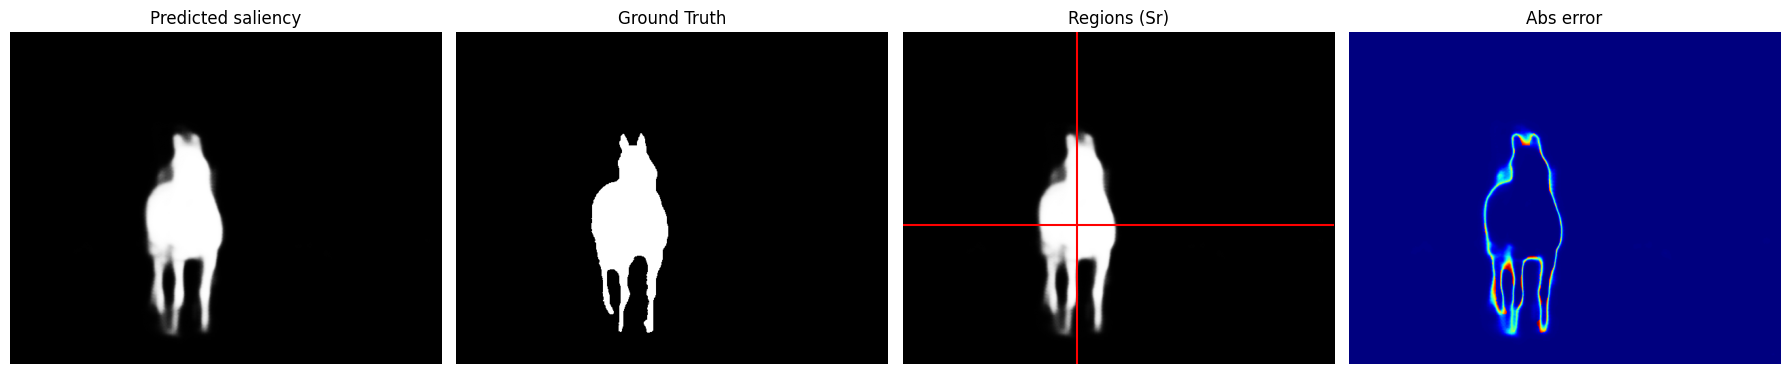

In [152]:
img = 'image_left8'
dataset = 'STERE'
gt_path = f"./gt/{dataset}/{img}.png"
pred_path = f"./pred/M0/{dataset}/{img}.png"
main(gt_path, pred_path)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

"""
Script: Method-vs-Metrics visualizer per dataset
------------------------------------------------
- Parses your Excel (like results.xlsx) where rows=methods and columns are grouped by dataset, each with metrics:
  [sm, wfm, mae, maxfmeasure, avgfmeasure, adpfmeasure, maxem, avgem, adpem,
   maxprecision, avgprecision, adpprecision, maxrecall, avgrecall, adprecall, msiou]
- Builds a MultiIndex dataframe: columns=(dataset, metric)
- For EACH dataset in DATASETS, produces:
    1) Heatmap of Methods × Metrics (normalized per metric for fair comparison)
    2) Bar chart of composite score (normalized across metrics, with mae inverted)
    3) Per-metric ranking bar charts (horizontal)
- All figures are saved under ./figs/<DATASET>/

USAGE:
  - Put this script next to your Excel file, or change FILE_PATH.
  - Run the script. Adjust DATASETS, TOP_N, and METRICS if needed.
"""

# ------------------
# Configuration
# ------------------
FILE_PATH = "PySODEvalToolkit-master/output/results.xlsx"        # path to your Excel file
SHEET_NAME = "Results"              # sheet containing the table
DATASETS = ["NJU2K", "NLPR", "STERE", "DES", "SSD", "LFSD", "SIP"]

# Metric order as provided
METRICS = [
    "sm", "wfm", "mae", "maxfmeasure", "avgfmeasure", "adpfmeasure",
    "maxem", "avgem", "adpem", "maxprecision", "avgprecision",
    "adpprecision", "maxrecall", "avgrecall", "adprecall", "msiou",
]

# Direction: True => higher is better, False => lower is better
HIGHER_IS_BETTER = {
    "sm": True, "wfm": True, "mae": False,
    "maxfmeasure": True, "avgfmeasure": True, "adpfmeasure": True,
    "maxem": True, "avgem": True, "adpem": True,
    "maxprecision": True, "avgprecision": True, "adpprecision": True,
    "maxrecall": True, "avgrecall": True, "adprecall": True, "msiou": True,
}

# How many top methods to show in composite/rank plots (set to None for all)
TOP_N = None

# ------------------
# Helpers
# ------------------

def _forward_fill_datasets(cols):
    """Given the header row names (e.g., ['methods','nlpr','Unnamed: 2', ...]),
    forward-fill dataset names across their metric columns."""
    result = []
    last_ds = None
    for c in cols:
        s = str(c)
        if s.lower().startswith("unnamed"):
            result.append(last_ds)
        elif s == "methods":
            result.append(None)
        else:
            last_ds = s
            result.append(last_ds)
    return result


def load_multiindex_results(file_path=FILE_PATH, sheet_name=SHEET_NAME):
    raw = pd.read_excel(file_path, sheet_name=sheet_name, header=0)

    # Row 0 contains metric names
    metrics_row = raw.iloc[0]

    # Forward-fill dataset labels
    datasets = _forward_fill_datasets(raw.columns)

    tuples = []
    for ds, m in zip(datasets[1:], metrics_row.iloc[1:]):
        if ds is None:
            continue
        ds_up = str(ds).strip().upper()
        m_name = str(m).strip().lower()
        tuples.append((ds_up, m_name))

    # Slice rows below the metric header
    methods = raw.iloc[1:, 0].reset_index(drop=True).rename("method")
    data_vals = raw.iloc[1:, 1:].reset_index(drop=True).copy()

    # Assign MultiIndex columns
    data_vals.columns = pd.MultiIndex.from_tuples(tuples, names=["dataset", "metric"])
    data_vals = data_vals.apply(pd.to_numeric, errors="coerce")

    # Drop empty rows safely (mask is aligned by index length now)
    mask_all_nan = data_vals.isna().all(axis=1)
    methods = methods.loc[~mask_all_nan].reset_index(drop=True)
    data_vals = data_vals.loc[~mask_all_nan].reset_index(drop=True)

    return methods, data_vals



def get_dataset_table(methods, data_multi, dataset, metrics_order=METRICS):
    ds = str(dataset).upper()
    if ds not in data_multi.columns.get_level_values(0):
        raise KeyError(f"Dataset '{ds}' not found. Available: {sorted(set(data_multi.columns.get_level_values(0)))}")
    sub = data_multi[ds].copy()  # columns=metrics

    # Keep only requested metrics that actually exist
    keep = [m for m in metrics_order if m in sub.columns]
    sub = sub[keep]

    # Attach method names as index
    sub.index = methods
    sub.index.name = "method"
    return sub


def normalize_per_metric(df, higher_is_better=HIGHER_IS_BETTER):
    """Column-wise min-max normalize to [0,1], flipping where lower-is-better."""
    norm = df.copy().astype(float)
    for col in norm.columns:
        col_min = norm[col].min(skipna=True)
        col_max = norm[col].max(skipna=True)
        if pd.isna(col_min) or pd.isna(col_max) or col_min == col_max:
            # If constant/empty, set to 0.5 for neutrality
            norm[col] = 0.5
            continue
        if not higher_is_better.get(col, True):
            # lower is better -> invert
            norm[col] = (col_max - norm[col]) / (col_max - col_min)
        else:
            norm[col] = (norm[col] - col_min) / (col_max - col_min)
    return norm


def composite_score(df_norm):
    """Average normalized score across metrics for each method."""
    return df_norm.mean(axis=1, skipna=True)


def save_table_as_image(df, filename="summary_table.png", max_rows=20):
    """
    Save a pandas DataFrame as a table image using matplotlib.
    """
    # Truncate if too many rows
    df_to_plot = df.head(max_rows)

    fig, ax = plt.subplots(figsize=(min(20, df_to_plot.shape[1]*2.5), 
                                    min(0.6*df_to_plot.shape[0]+1, 20)))
    ax.axis("off")

    table = ax.table(cellText=df_to_plot.values,
                     colLabels=df_to_plot.columns,
                     cellLoc="center", loc="center")

    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.2, 1.2)

    # Make header bold
    for key, cell in table.get_celld().items():
        if key[0] == 0:  # header row
            cell.set_text_props(weight="bold", color="white")
            cell.set_facecolor("#40466e")

    plt.tight_layout()
    plt.savefig(filename, dpi=200, bbox_inches="tight")
    plt.close()
    print(f"📊 Summary table saved as image: {filename}")

# ------------------
# Plotters
# ------------------

def plot_heatmap(df_norm, title, save_path):
    plt.figure(figsize=(max(8, df_norm.shape[1]*0.8), max(6, df_norm.shape[0]*0.35)))
    sns.heatmap(df_norm, annot=True, fmt=".2f", cmap="viridis", cbar=True)
    plt.title(title)
    plt.xlabel("Metric")
    plt.ylabel("Method")
    plt.tight_layout()
    plt.savefig(save_path, dpi=200)
    plt.close()


def plot_composite_bar(scores, title, save_path, top_n=TOP_N):
    s = scores.sort_values(ascending=False)
    if top_n is not None:
        s = s.head(top_n)
    plt.figure(figsize=(10, max(4, 0.35*len(s))))
    plt.barh(s.index.astype(str), s.values)
    plt.gca().invert_yaxis()
    plt.title(title)
    plt.xlabel("Composite score (0-1, normalized across metrics)")
    plt.tight_layout()
    plt.savefig(save_path, dpi=200)
    plt.close()


def plot_metric_rankings(df, dataset, out_dir, top_n=TOP_N):
    """For each metric, draw a horizontal ranking bar chart of methods."""
    for metric in df.columns:
        s = df[metric].copy()
        # For metrics with lower-better, flip so that higher bars are better for visualization
        if not HIGHER_IS_BETTER.get(metric, True):
            # We'll plot the original values but sort ascending (lower is better)
            ranked = s.sort_values(ascending=True)
            xlabel = f"{dataset} · {metric} (lower is better)"
        else:
            ranked = s.sort_values(ascending=False)
            xlabel = f"{dataset} · {metric} (higher is better)"

        if top_n is not None:
            ranked = ranked.head(top_n)

        plt.figure(figsize=(10, max(4, 0.35*len(ranked))))
        plt.barh(ranked.index.astype(str), ranked.values)
        if HIGHER_IS_BETTER.get(metric, True):
            plt.gca().invert_yaxis()
        plt.xlabel(xlabel)
        plt.title(f"{dataset}: {metric} ranking by method")
        plt.tight_layout()
        fname = out_dir / f"{dataset.lower()}_{metric}_ranking.png"
        plt.savefig(fname, dpi=200)
        plt.close()


# ------------------
# Main
# ------------------
if __name__ == "__main__":
    out_root = Path("figs")
    out_root.mkdir(parents=True, exist_ok=True)

    methods, data_multi = load_multiindex_results(FILE_PATH, SHEET_NAME)

    # Iterate over each requested dataset
    for ds in DATASETS:
        try:
            table = get_dataset_table(methods, data_multi, ds, METRICS)
        except KeyError as e:
            print(e)
            continue

        # Normalize per metric for fair visual comparison
        table_norm = normalize_per_metric(table, HIGHER_IS_BETTER)
        scores = composite_score(table_norm)

        ds_dir = out_root / ds.upper()
        ds_dir.mkdir(parents=True, exist_ok=True)

        # 1) Heatmap of normalized values
        plot_heatmap(
            table_norm,
            title=f"{ds.upper()} · Methods × Metrics (normalized)",
            save_path=ds_dir / f"{ds.lower()}_heatmap_normalized.png",
        )

        # 2) Composite score bar chart
        plot_composite_bar(
            scores,
            title=f"{ds.upper()} · Composite score (normalized across metrics)",
            save_path=ds_dir / f"{ds.lower()}_composite_score.png",
            top_n=TOP_N,
        )

        # 3) Per-metric rankings (original scale)
        plot_metric_rankings(table, ds.upper(), ds_dir, top_n=TOP_N)

    # ------------------
    # Summary Table
    # ------------------
    summary = pd.DataFrame({"method": methods})

    for ds in DATASETS:
        try:
            table = get_dataset_table(methods, data_multi, ds, METRICS)
            table_norm = normalize_per_metric(table, HIGHER_IS_BETTER)
            scores = composite_score(table_norm)
            summary[ds.upper()] = scores.values
        except KeyError:
            print(f"Dataset {ds} not found, skipping...")

    # Overall average composite score
    summary["Overall"] = summary[DATASETS].mean(axis=1, skipna=True)

    # Sort by overall performance
    summary = summary.sort_values("Overall", ascending=False).reset_index(drop=True)

    save_table_as_image(summary, filename="figs/summary_table.png")



    print("✅ Done. Check the 'figs/' folder for outputs.")

📊 Summary table saved as image: figs/summary_table.png
✅ Done. Check the 'figs/' folder for outputs.


In [ ]:
import os
import matplotlib.pyplot as plt
import cv2
import glob

# دیتاست‌ها
datasets = ['NJU2K', 'NLPR', 'STERE', 'DES', 'SSD', 'LFSD', 'SIP']

# مدل‌ها
method_display_names = {
    'bbsnet': 'M0',
    # 'fullspatial_cpa_stack_sl': 'مدل ۱',
    'fullspatial_cpa_stack_sl3': 'M2',
    'fullspatial_stack_sl_depth3':  'M3',
    'fullspatial_cpa_stack_sl_p8': 'M4',
    # 'patchify_sl': 'مدل ۵',
    # 'fullspatial_stack_sl_cross': 'مدل ۶',
    'fullspatial_stack_sl_depth3_noc': 'M7',
    'noc_nostack': 'M8',
    'combined': 'M9',
    'p8_noc': 'M10',
}

# مسیرها
dataset_root = "/home/mahdi/Documents/bach_prj/repo/BBS_dataset/RGBD_for_test"
pred_root = "/home/mahdi/Documents/bach_prj/repo/BBS-Net/pred"

def load_and_resize(path, size=(100,100), gray=False):
    if not path or not os.path.exists(path):
        return None
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE if gray else cv2.IMREAD_COLOR)
    if img is None:
        return None
    if not gray:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, size, interpolation=cv2.INTER_LINEAR)
    return img

def find_file_with_prefix(folder, prefix):
    matches = glob.glob(os.path.join(folder, prefix + ".*"))
    return matches[0] if matches else None

# تعداد ردیف‌ها
n_rows = 3 + len(method_display_names)
n_cols = len(datasets)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols, n_rows))
plt.subplots_adjust(wspace=0.02, hspace=0.02)

img = [0, 0, 7, 1, 5, 1, 1]
for col, dataset in enumerate(datasets):
    dataset_path = os.path.join(dataset_root, dataset)
    rgb_dir = os.path.join(dataset_path, "RGB")
    depth_dir = os.path.join(dataset_path, "depth")
    gt_dir = os.path.join(dataset_path, "GT")

    id = img[col]
    rgb_file = sorted(os.listdir(rgb_dir))[id]
    name_wo_ext = os.path.splitext(rgb_file)[0]



    rgb = load_and_resize(os.path.join(rgb_dir, rgb_file))
    depth_file = find_file_with_prefix(depth_dir, name_wo_ext)
    gt_file = find_file_with_prefix(gt_dir, name_wo_ext)

    depth = load_and_resize(depth_file, gray=True) if depth_file else None
    gt = load_and_resize(gt_file, gray=True) if gt_file else None

    if rgb is not None:
        axes[0, col].imshow(rgb)
    if depth is not None:
        axes[1, col].imshow(depth, cmap="gray")
    if gt is not None:
        axes[2, col].imshow(gt, cmap="gray")

    axes[0, col].set_title(dataset, fontsize=10)

    for row, (model_key, model_disp) in enumerate(method_display_names.items(), start=3):
        pred_file = find_file_with_prefix(os.path.join(pred_root, model_key, dataset), name_wo_ext)
        pred = load_and_resize(pred_file, gray=True) if pred_file else None
        if pred is not None:
            axes[row, col].imshow(pred, cmap="gray")
        axes[row, col].axis("off")

# 🔹 لیبل‌ها (سمت چپ نزدیک هر ردیف)
row_labels = ["RGB", "Depth", "GT", "M0"] + [f"{i}" for i in list(method_display_names.values())[1:]]
for row, label in enumerate(row_labels):
    axes[row, 0].text(-0.1, 0.5, label, transform=axes[row, 0].transAxes,
                      fontsize=10, va="center", ha="right", fontweight="bold")


# همه محورها خاموش
for ax in axes.flatten():
    ax.axis("off")

plt.tight_layout()
plt.savefig('result.png', dpi=300, bbox_inches='tight')
plt.show()


In [10]:
import os
import cv2
import numpy as np

dataset_root = "/home/mahdi/Documents/bach_prj/repo/BBS_dataset/RGBD_for_test/NJU2K"
rgb_dir = os.path.join(dataset_root, "RGB")
gt_dir = os.path.join(dataset_root, "GT")
out_dir = os.path.join(dataset_root, "Compressed")
os.makedirs(out_dir, exist_ok=True)

rgb_files = sorted([f for f in os.listdir(rgb_dir) if f.endswith(".jpg")])
print(f"Found {len(rgb_files)} RGB images")

for rgb_name in rgb_files:
    base_name = os.path.splitext(rgb_name)[0]

    rgb_path = os.path.join(rgb_dir, rgb_name)
    gt_path = os.path.join(gt_dir, base_name + ".png")

    if not os.path.exists(gt_path):
        print(f"[WARNING] GT not found for {rgb_name}")
        continue

    img = cv2.imread(rgb_path)
    mask = cv2.imread(gt_path, cv2.IMREAD_GRAYSCALE)
    if img is None or mask is None:
        print(f"[ERROR] Failed to read {rgb_name}")
        continue

    mask_bin = (mask > 128).astype(np.uint8)

    # نسخه کم‌کیفیت فقط با کاهش مقیاس رنگ (simulate low quality)
    lowq_img = (img // 4) * 4  # ساده‌ترین شبیه‌سازی فشرده‌سازی
    lowq_img = lowq_img.astype(np.uint8)

    # ترکیب: نواحی مهم از تصویر اصلی، بقیه از lowq
    final_img = np.where(mask_bin[:, :, None] == 1, img, lowq_img)

    final_path = os.path.join(out_dir, base_name + "_compressed.jpg")
    cv2.imwrite(final_path, final_img, [int(cv2.IMWRITE_JPEG_QUALITY), 85])

    orig_size = os.path.getsize(rgb_path) / 1024
    final_size = os.path.getsize(final_path) / 1024
    print(f"[OK] {rgb_name}: orig={orig_size:.1f} KB -> compressed={final_size:.1f} KB")


Found 500 RGB images
[OK] 000008_left.jpg: orig=75.5 KB -> compressed=96.3 KB
[OK] 000013_left.jpg: orig=44.4 KB -> compressed=57.8 KB
[OK] 000017_left.jpg: orig=58.5 KB -> compressed=75.2 KB
[OK] 000023_left.jpg: orig=76.1 KB -> compressed=53.1 KB
[OK] 000025_left.jpg: orig=28.9 KB -> compressed=37.2 KB
[OK] 000026_left.jpg: orig=103.3 KB -> compressed=62.4 KB
[OK] 000027_left.jpg: orig=63.1 KB -> compressed=80.5 KB
[OK] 000028_left.jpg: orig=129.2 KB -> compressed=41.8 KB
[OK] 000034_left.jpg: orig=19.3 KB -> compressed=25.1 KB
[OK] 000040_left.jpg: orig=52.5 KB -> compressed=66.7 KB
[OK] 000043_left.jpg: orig=41.4 KB -> compressed=53.0 KB
[OK] 000084_left.jpg: orig=99.0 KB -> compressed=46.1 KB
[OK] 000087_left.jpg: orig=78.0 KB -> compressed=22.3 KB
[OK] 000089_left.jpg: orig=40.6 KB -> compressed=51.9 KB
[OK] 000090_left.jpg: orig=50.7 KB -> compressed=65.5 KB
[OK] 000097_left.jpg: orig=44.3 KB -> compressed=56.4 KB
[OK] 000100_left.jpg: orig=30.6 KB -> compressed=38.5 KB
[OK] 000